# Home energy management under peak demand tariffs

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib as mpl
from matplotlib import pyplot as plt
# import matplotlib.dates as mdates
import tqdm
# import warnings
import matplotlib.ticker as ticker

from src import *

mpl.rc("figure", figsize=(10,5))
mpl.rc("lines", linewidth=2)
mpl.rc("font", serif="Computer Modern Roman")

save_figs = False

## Data loading

In [2]:
# Load data
baseline = pd.read_pickle("data/load_baseline.pickle")
load_data = pd.read_pickle("data/load_data.pickle")
price_data = pd.read_pickle("data/price_data.pickle")
autoreg_residual_params = pd.read_pickle("data/autoreg_residual_params.pickle")

## Constants and simulation parameters

In [3]:
storage_capacity = 15  # kWh
price_peak_demand = 252  # NOK/kWh

len_interval = (baseline.index[1] - baseline.index[0]).seconds / 3600
intervals_per_day = int(24 / len_interval)

T = intervals_per_day * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")
sim_start_time = baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T

## Simulation setup

This section sets up the simulation, including the network and the optimization problem.

In [4]:
params = {
    "T": T,
    "electricity_demand": load_data[sim_start_time:sim_end_time].values,
    "storage_capacity": storage_capacity,
    "initial_storage": storage_capacity / 2,
    "electricity_price": price_data[sim_start_time:sim_end_time].values,
    "month_slices": create_month_slices(load_data[sim_start_time:sim_end_time].index),
    "price_peak_demand": price_peak_demand,
    "prev_peak_demand": 0
}

def make_network(params):
    # Define the network and its components
    load = Load(power=params["electricity_demand"])
    storage = Storage(energy_max=params["storage_capacity"],
                      discharge_max=params["storage_capacity"] / 2,
                      charge_max=params["storage_capacity"] / 2,
                      energy_init=params["initial_storage"],
                      energy_final=params["storage_capacity"] / 2)
    grid = Grid(price_buy=params["electricity_price"],
                price_peak_demand=params["price_peak_demand"],
                prev_peak_demand=params["prev_peak_demand"],
                month_slices=params["month_slices"])

    net = Net([grid.terminals[0], storage.terminals[0], load.terminals[0]])

    # Create a network group and initialize the optimization problem
    network = Group([grid, storage, load], [net])
    network.init_problem(time_horizon=params["T"])

    return network

## Plotting functions

This section defines functions for plotting and printing the results of the simulation.

In [5]:
def cost_breakdown(network):
    p_grid = pd.Series(data=-network.devices[0].terminals[0].power, index=load_data[sim_start_time:sim_end_time].index)
    monthly_peak_demands = p_grid.resample('M').max().values
    cost_electricity_use = np.sum(p_grid.values * price_data[sim_start_time:sim_end_time])
    cost_peak_demand = np.sum(monthly_peak_demands * price_peak_demand)
    
    return cost_electricity_use, cost_peak_demand

def plot_and_print_results(network, cost, params, method=None):
    p_grid = pd.Series(data=-network.devices[0].terminals[0].power, index=load_data[sim_start_time:sim_end_time].index)

    monthly_peak_demands = p_grid.resample('M').max().values
    peak_demand = p_grid.groupby(p_grid.index.to_period('M')).transform('max').to_numpy()

    cost_electricity_use = np.sum(p_grid.values * price_data[sim_start_time:sim_end_time])
    cost_peak_demand = np.sum(monthly_peak_demands * price_peak_demand)
    total_cost = cost_electricity_use + cost_peak_demand

    # Print the results
    print(f"{method} cost: {cost:,.2f} NOK")
    print("Cost breakdown:")
    print(f"\tCost of electricity use: {cost_electricity_use:,.2f} NOK ({100 * cost_electricity_use / total_cost:.0f}% of total cost)")
    print(f"\tCost of peak demand: {cost_peak_demand:,.2f} NOK ({100 * cost_peak_demand / total_cost:.0f}% of total cost)")

    # Plot power demand and peak demand
    fig, ax = plt.subplots()
    ax.plot(p_grid.index, p_grid.values, color="blue", label="Power demand from the grid")
    ax.plot(p_grid.index, peak_demand, color="red", label="Monthly peak demand")
    ax.set_ylabel("Power (kW)")
    ax.legend(loc='upper center', ncol=2)
    ax.set_title(f"Storage capacity: {params['storage_capacity']:.0f} kW")
    format_x_axis(ax)

## Prescient simulations (perfect knowledge of future power demand)

In this section, we solve the prescient dynamic optimal power flow problem, i.e., we assume perfect knowledge of future power demands. This case is unrealistic, but it will give us an informative lower bound on the cost as no real-time control policy can do better than this. 

### No storage

Prescient cost: 30,136.18 NOK
Cost breakdown:
	Cost of electricity use: 8,676.61 NOK (29% of total cost)
	Cost of peak demand: 21,459.56 NOK (71% of total cost)


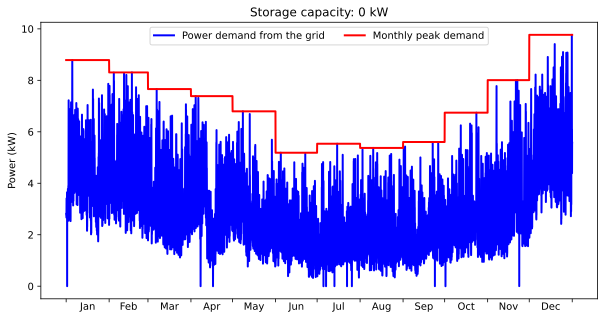

In [6]:
params["storage_capacity"] = 0
params["initial_storage"] = 0
dopf_network = make_network(params)
cost_dopf = dopf_network.solve(verbose=False)
plot_and_print_results(dopf_network, cost_dopf, params, method="Prescient")

### 5 kW storage capacity

Prescient cost: 23,756.05 NOK
Cost breakdown:
	Cost of electricity use: 8,517.36 NOK (36% of total cost)
	Cost of peak demand: 15,238.69 NOK (64% of total cost)


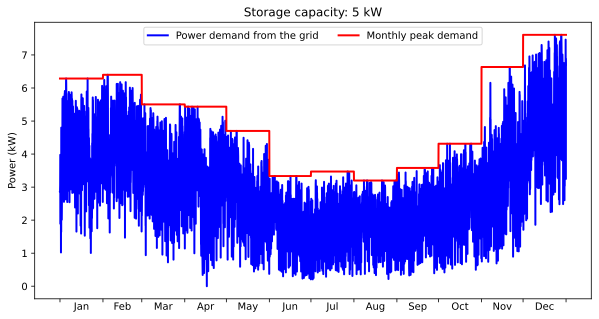

In [7]:
params["storage_capacity"] = 5
params["initial_storage"] = 5/2
dopf_network = make_network(params)
cost_dopf = dopf_network.solve(verbose=False)
plot_and_print_results(dopf_network, cost_dopf, params, method="Prescient")

### 15 kW storage capacity

Prescient cost: 20,043.72 NOK
Cost breakdown:
	Cost of electricity use: 8,309.77 NOK (41% of total cost)
	Cost of peak demand: 11,733.95 NOK (59% of total cost)


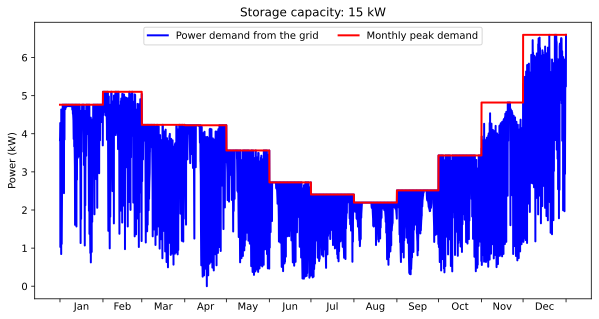

In [8]:
params["storage_capacity"] = 15
params["initial_storage"] = 15/2
dopf_network = make_network(params)
cost_dopf = dopf_network.solve(verbose=False)
plot_and_print_results(dopf_network, cost_dopf, params, method="Prescient")

### 30 kW storage capacity

Prescient cost: 18,856.22 NOK
Cost breakdown:
	Cost of electricity use: 8,359.85 NOK (44% of total cost)
	Cost of peak demand: 10,496.37 NOK (56% of total cost)


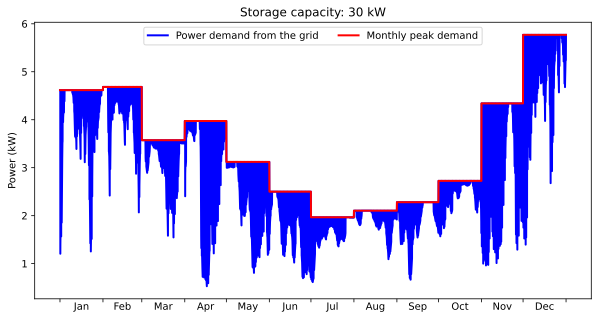

In [9]:
params["storage_capacity"] = 30
params["initial_storage"] = 30/2
dopf_network = make_network(params)
cost_dopf = dopf_network.solve(verbose=False)
plot_and_print_results(dopf_network, cost_dopf, params, method="Prescient")

## Sensitivity analysis of storage capacity on cost

In this section, we perform a sensitivity analysis to understand the impact of varying storage capacities on the total cost and its breakdown into electricity use cost and peak demand cost. By simulating a range of storage capacities, we can gain insights into the relationship between storage capacity and cost components. The results are visualized using bar plots to provide a clear representation of the cost distribution.

Performing sensitivity analysis: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


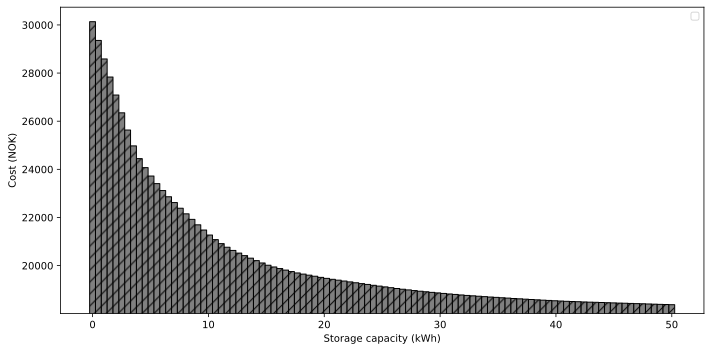

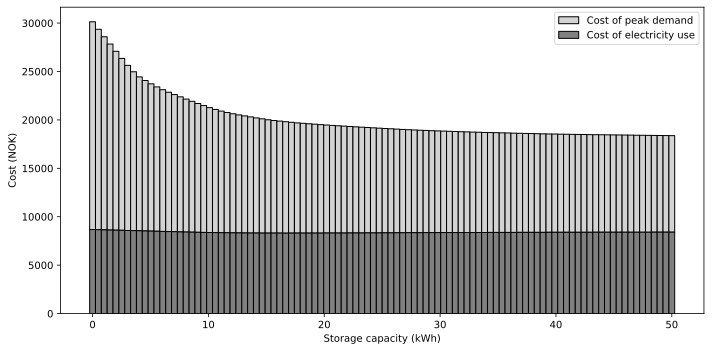

In [10]:
# Define the storage capacity range
storage_capacities = np.linspace(0, 50, 100)

# Initialize arrays for storing costs and cost breakdown
cost = np.zeros(len(storage_capacities))
cost_electricity_use = np.zeros(len(storage_capacities))
cost_peak_demand = np.zeros(len(storage_capacities))

# Run simulations for various storage capacities
for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities), desc="Performing sensitivity analysis"):
    # Update problem data
    params["storage_capacity"] = capacity
    params["initial_storage"] = capacity / 2
    dopf_network = make_network(params)
    cost[i] = dopf_network.solve(verbose=False)
    cost_electricity_use[i], cost_peak_demand[i] = cost_breakdown(dopf_network)

# Plot the results: Total cost vs storage capacity
fig, ax = plt.subplots()
ax.bar(storage_capacities, cost, width=0.5, color='gray', edgecolor='black', hatch='//')

ax.set_xlabel("Storage capacity (kWh)")
ax.set_ylabel("Cost (NOK)")
ax.set_ylim(np.min(cost) * 0.98, np.max(cost) * 1.02)  # Set y-axis limits with extra margin
ax.legend()
plt.tight_layout()

if save_figs:
    plt.savefig("figures/cost_vs_storage_capacity.pdf")
    
# Plot the results: Cost breakdown vs storage capacity
fig, ax = plt.subplots()
ax.bar(storage_capacities, cost_peak_demand, width=0.5, color='lightgray', edgecolor='black', hatch='', bottom=cost_electricity_use, label="Cost of peak demand")
ax.bar(storage_capacities, cost_electricity_use, width=0.5, color='gray', edgecolor='black', hatch='', label="Cost of electricity use")

ax.set_xlabel("Storage capacity (kWh)")
ax.set_ylabel("Cost (NOK)")
ax.legend()
plt.tight_layout()

if save_figs:
    plt.savefig("figures/cost_breakdown_vs_storage_capacity.pdf")


## MPC simulations (predictive model of future power demand)

### MPC with a seasonal baseline forecast

In [11]:
T_MPC = intervals_per_day * 30

params = {"T": T_MPC,
          "electricity_demand": load_data[sim_start_time:sim_start_time+T_MPC].values,
          "storage_capacity": storage_capacity,
          "initial_storage": storage_capacity // 2,
          "electricity_price": price_data[sim_start_time:sim_start_time+T_MPC].values,
          "month_slices": create_month_slices(load_data[sim_start_time:sim_start_time+T_MPC].index),
          "price_peak_demand": price_peak_demand,
          "prev_peak_demand": 0}

baseline_mpc_params = params.copy()
autoregressive_mpc_params = params.copy()


baseline_mpc = BaselineMPC(make_network, baseline_mpc_params, load_data, price_data, baseline, sim_start_time)
energy_stored, power, peak_demand, cost_electricity_use, cost_peak_demand = baseline_mpc.run(T)
print(f"cost: {cost_electricity_use + cost_peak_demand:,.2f} NOK")

plt.figure()
plt.plot(power, color="b")
plt.plot(peak_demand, color="r")

  0%|          | 0/8760 [00:00<?, ?it/s]


AttributeError: 'Group' object has no attribute 'problem'

### MPC with a seasonal baseline + AR residual forecast

In [ ]:
autoregressive_mpc = AutoregressiveMPC(make_network, autoregressive_mpc_params, load_data, price_data, baseline, sim_start_time, T_MPC, autoreg_residual_params)
energy_stored, power, peak_demand, cost_electricity_use, cost_peak_demand = autoregressive_mpc.run(T)
print(f"cost: {cost_electricity_use + cost_peak_demand:,.2f} NOK")

plt.figure()
plt.plot(power, color="b")
plt.plot(peak_demand, color="r")